# Static maps

Static visualizations of geographic information are useful for many purposes during a data analysis process, such as data exploration and communicating the results. Maps produced in Python can be exported to various image formats and used, for example, in reports and scientific articles. 

[Mapping tools in `geopandas`](https://geopandas.org/en/stable/docs/user_guide/mapping.html) [^geopandas_mappingtools] and `xarray` allow creating simple static maps easily. Similar to `pandas` `DataFrames`, `geopandas` and `xarray` have a `.plot()` method that can be used to visualize data from wanted columns of the `geopandas.GeoDataFrame` or data variables in a `xarray.Dataset`. In the background, the methods use `matplotlib` for creating the plots and we can use [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) [^matplotlib_pyplot] tools for further customizing our figures. The basics of `matplotlib` are covered in Part I chapter 4, and here we will apply some of these techniques for plotting static maps. Additionally, we will explore how to enhance our maps by adding basemaps with [`contextily`](https://github.com/darribas/contextily) [^contextily].

## Creating a vector choropleth map

We will practice plotting static maps using sample data from Helsinki, Finland. The sample data contains information about travel times across the region from the Helsinki Region Travel Time Matrix dataset ({cite}`Tenkanen2020`). 
We will also incorporate [transport network data from Helsinki Region Transport](https://www.avoindata.fi/data/en_GB/dataset/hsl-n-linjat) [^HSL_opendata] to add spatial context. Let's start by importing the required modules and defining our data sources.

In [1]:
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

data_dir = Path("../data")
grid_fp = data_dir / "TravelTimes_to_5975375_RailwayStation.shp"
transport_fp = data_dir / "HSL%3An_linjat.zip"

# Read files
grid = gpd.read_file(grid_fp)
transport = gpd.read_file(transport_fp)

# Filtering out some useful transport features for our map
metro = transport.loc[transport["JL_LAJI"] == "06"]
train = transport.loc[transport["JL_LAJI"] == "12"]

The travel time data contains multiple columns with information about travel times and distances from each statistical grid square to the central railway station in Helsinki. 

In [2]:
grid.columns

Index(['car_m_d', 'car_m_t', 'car_r_d', 'car_r_t', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'geometry'],
      dtype='object')

For a detailed description of each column, see Table 3 in {cite}`Tenkanen2020`. We will use column `'pt_r_t'` which contains information about travel time in minutes to the central railway station by public transportation in rush hour traffic. Missing data are presented with value -1. Let's set the missing values as `NaN` before proceeding:

In [3]:
grid = grid.replace(-1, np.nan)

### Plotting the data and adding a legend

Now we can use `geopandas` for visualizing a simple map representing the rush hour public transport travel times (`'pt_r_t'`). Colors in the map are assigned based on the values from this column. 

Let's also add a map legend to add information about what is displayed. Additional keywords for controlling the legend can be added through the `legend_kwds` parameter. When plotting the `GeoDataFrame` using basic settings, the legend will be a [colorbar object](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html) [^matplotlib_colorbar] and the legend keyword arguments will control how the colorbar looks. For example, we can add a `label` for our colorbar legend. For additional legend options, have a look at [`geopandas` mapping tools](https://geopandas.org/en/stable/docs/user_guide/mapping.html) [^geopandas_mappingtools] and [`matplotlib` legend guide](https://matplotlib.org/tutorials/intermediate/legend_guide.html) [^matplotlib_legend].

<Axes: >

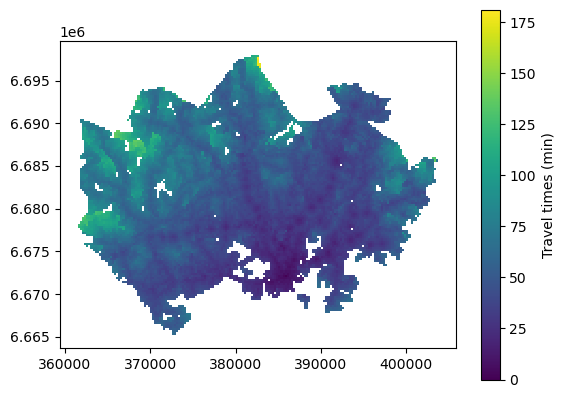

In [4]:
grid.plot(column="pt_r_t", legend=True, legend_kwds={"label": "Travel times (min)"})

_**Figure 8.1**. Simple static map plotted using `geopandas`. The color gradient represents travel times by public transport to the central railway station in Helsinki. Data source: Tenkanen & Toivonen 2020._

What we have here is a `choropleth map` where the colors of each grid square polygon are based on values from the column `pt_r_t`. Such a simple map is helpful for getting a quick overview of the underlying data. However, we can further enhance the visualization to better communicate the patterns and to create an effective visualization. 



### Adding layers

The power of geographic information often relies on overlaying multiple features and exploring their spatial relations. Here, we can visualize the transport network data on top of the travel time information to add spatial context in our map. In order to plot multiple layers in the same figure, the first thing is to check the coordinate reference system (CRS) of each layer and verify that they match:

In [5]:
# Check the crs of each layer
print(grid.crs)
print(metro.crs)
print(train.crs)

EPSG:3067
EPSG:4326
EPSG:4326


All layers have a defined CRS, but we can see that the coordinate reference system definitions don't match, which will be a problem for plotting all layers in the same figure. The grid is in ETRS89 / TM35FIN (EPSG:3067), which is an appropriate map projection for visualizing data from Finland. Roads and the metro are in WGS 84 (EPSG:4326) meaning that the coordinates are represented in latitudes and longitudes. Let's see what happens if trying to plot all three layers in the same figure without re-projecting the data:

<Axes: >

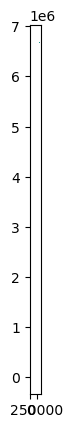

In [6]:
ax = grid.plot(column="pt_r_t")
train.plot(ax=ax)
metro.plot(ax=ax)

_**Figure 8.2**. Failed attempt to plot a static map with multiple layers._

We need to re-project the data in order to get the layers in the same coordinate space. In this case, we can re-project the linear features (train and metro) from WGS 84 to ETRS89 / TM35FIN (EPSG:3067) to get all data into a planar coordiante reference system. To ensure identical crs definitions, we can get the crs definition based on the grid layer when transforming the geometries.

In [7]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
train = train.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

Let's verify that the layer are in the same coordinate reference system:

In [8]:
# Check the crs of each layer
print(grid.crs)
print(metro.crs)
print(train.crs)

EPSG:3067
EPSG:3067
EPSG:3067


Once the data share the same projection, we can finally create a multi-layer map. Let's start from the "bottom-most" layer and plot the travel time grid layer first and store the plot object in the variable `ax`. Then we can draw the train and metro line in the same plot through referring to this object when plotting:

<Axes: >

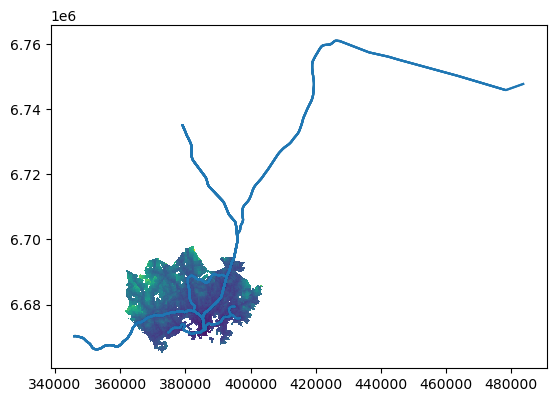

In [9]:
ax = grid.plot(column="pt_r_t")
train.plot(ax=ax)
metro.plot(ax=ax)

_**Figure 8.3**. Static map with multiple layers displaying the original data extent. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

Now our layers are nicely aligned, but the map stills needs some further improvement, as the transport network data extends beyond the grid data.

### Cropping the map extent

The desired extent of our map would cover the travel time data extent. We could pre-process the data before plotting and crop the train line geometry to fit our desired map extent. However, we can avoid modifying the original data and crop the figure when creating the plot. To achieve this, we can get the desired plot extent from the `total_bounds` of the grid layer and then limit the x- and y-axis based on this information. 

(6665250.00004393, 6698000.000038021)

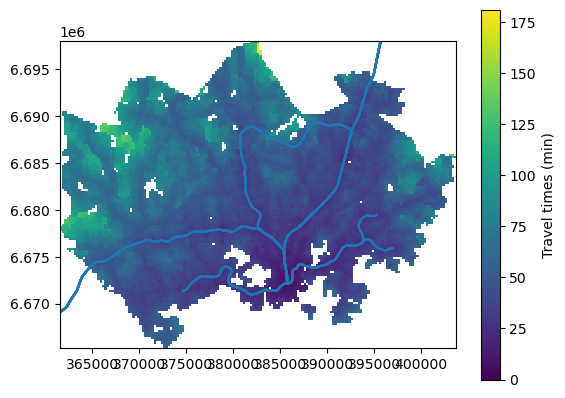

In [10]:
# Plot the data layers
ax = grid.plot(
    column="pt_r_t", legend=True, legend_kwds={"label": "Travel times (min)"}
)
train.plot(ax=ax)
metro.plot(ax=ax)

# Set axis view limits based on the total bounds of the grid layer
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])

_**Figure 8.4**. Static map with multiple layers displaying the grid data extent. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

### Adding a classification scheme

Next, we can change the classification scheme to determine the assignment of values to distinct classes for the visualization. For doing this, we need to have `mapclassify` package installed. See chapter 6.1 for more information about `mapclassify` and different classification schemes. 

The default visualization doesn't display the travel time values optimally. One intuitive way to visaulize travel times is to use equal intervals for travel times that are within a reasonable travel time distance, and to classify relatively long distances all in one category. We can achieve this by creating our own user-defined classification scheme with manually selected break values. 

### Adjusting the map legend

Now that we are using `mapclassify` to render the values, the map legend will look bit different in comparison to the previous map. We can control the position and title of the legend through legend keywords arguments (`legend_kwds`). We can use `bbox_to_anchor` to position the legend item so that it does not overlap and cover our map extent.  An alternative way to achieve the same thing would be to add `ax.get_legend().set_bbox_to_anchor((1.4, 1))` after plotting the data via `geopandas`. For further tips on customizing choropleth map legends, have a look at [`geopandas examples gallery`](https://geopandas.org/en/stable/gallery/choro_legends.html) [^geopandas_choro_legends].

(6665250.00004393, 6698000.000038021)

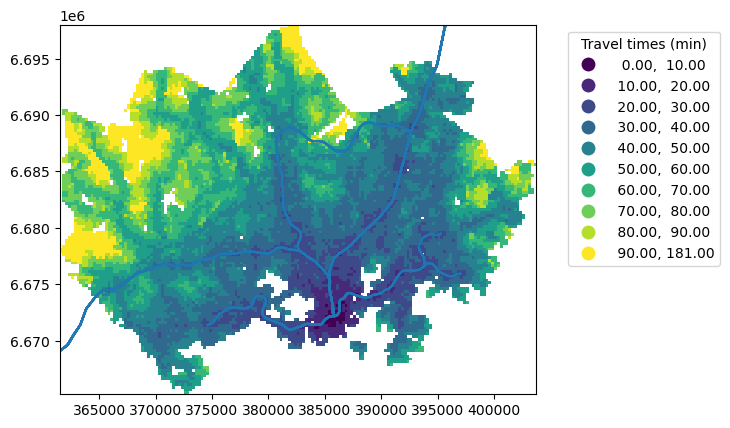

In [11]:
break_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]

ax = grid.plot(
    column="pt_r_t",
    scheme="UserDefined",
    classification_kwds={"bins": break_values},
    legend=True,
    legend_kwds={"title": "Travel times (min)", "bbox_to_anchor": (1.4, 1)},
)

train.plot(ax=ax)
metro.plot(ax=ax)

# Set axis view limits based on the total bounds of the grid layer
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])

_**Figure 8.5**. Static map with multiple layers displaying the grid data extent. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

In comparison to the previous maps, the differences in travel times are now more pronounced highlighting lower travel times near the central railway station. Notice also that we now have a different type of map legend that shows the associated class bins, now that we used a classification scheme. 

### Choosing colors

Colors are an important component of any cartographic visualization. Display settings for map features, such as color and linewidth are easy to configure directly when plotting the data via `geopandas`. For changing the colors of the choropleth map, we can use the `cmap` parameter. There are various [colormap options via `matplotlib` ](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib) [^matplotlib_colormaps]. For line features, we can change the colors using the `color` parameter using the various [color options via `matplotlib` ](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors) [^matplotlib_colors]. Transparency can be added using the `alpha` parameter (this parameter ranges from 0 to 1 where 0 is fully transparent). 

### Adding a scalebar

A scalebar is an essential element of an informative map. While a scalebar isn't always necessary, it often adds value by clarifying the data range and geographic scale. A scalebar can be added using the `maplotlib-scalebar` library, which needs to be installed separately in addition to `matplotlib`. Adding a scalebar is easy as long as the data are in a projected metric coordinate reference system. The `ScaleBar` object only requires one parameter, `dx`, which indicates a size of one pixel in real world units. For a metric CRS, we can simply set `dx=1`. For tips on how to customize the scalebar, have a look at [`geopandas` examples gallery](https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html#Adding-a-scale-bar-to-a-matplotlib-plot) [^scalebar_geopandas].

### Final customization 

Finally, we can apply some final adjustments on the figure layout, such as `tight_layout` that automatically adjusts the map elements to fit the figure extent. We can also hide visual components of the x- and y-axis if they don't add value to our visualization. 

In sum, let's apply all these customizations when visualizing our data: 

- Changing the choropleth map color.
- Changing line colors.
- Changing the linewidth of line features.
- Adding transparency.
- Adding a legend.
- Cropping the figure by limiting x- and y-axis. 
- Using a `tight_layout` to adjust the subplot to fit in the figure.
- Hide the coordinate values through setting x- and y- axis off.

Furthermore, we can save the figure as PNG image.

In [12]:
from matplotlib_scalebar.scalebar import ScaleBar

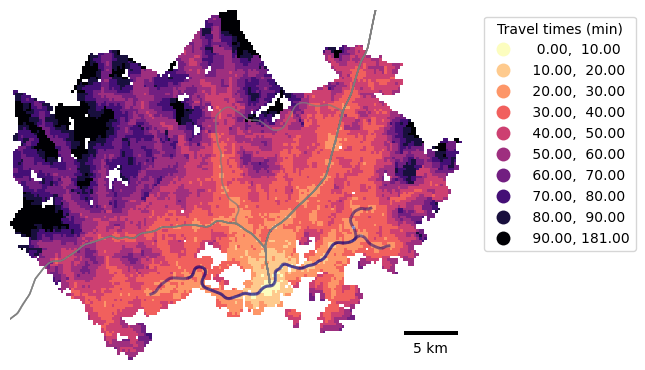

In [13]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="magma_r",
    scheme="UserDefined",
    classification_kwds={"bins": break_values},
    legend=True,
    legend_kwds={"title": "Travel times (min)", "bbox_to_anchor": (1.4, 1)},
)

# Add roads and change the color, linewidth and and transparency
train.plot(ax=ax, color="grey", linewidth=1, alpha=0.2)

# Add metro and change the color, linewidth and and transparency
metro.plot(ax=ax, color="darkblue", linewidth=2, alpha=0.1)

# Set axis view limits based on the total bounds of the grid layer
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])

# Add scalebar
ax.add_artist(ScaleBar(dx=1, location="lower right"))

# Set the x and y axis off
plt.axis("off")

# Adjust padding around the subplot
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

_**Figure 8.6**.  Static map with multiple layers and a scale bar. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

## Multi-panel map

We can plot two subplots side by side displaying travel times by different modes of transport using `geopandas` and `matplotlib`. Let's use the same classification scheme as earlier for plotting travel times to the central railway station by car and public transport. 

In this case, we can plot only one legend, as the two maps use an identical classification. We can add interval brackets on our legend to denote open and closed intervals. An open interval is denoted with parentheses and it does not inlcude the endpoint values. A closed interval is denoted with square brackets and it includes both endpoints. Most of the intervals in our classificaion scheme are half-open (for example, `(10, 20]`) so that the lower bound is not included in the interval, but the upper bound is. 

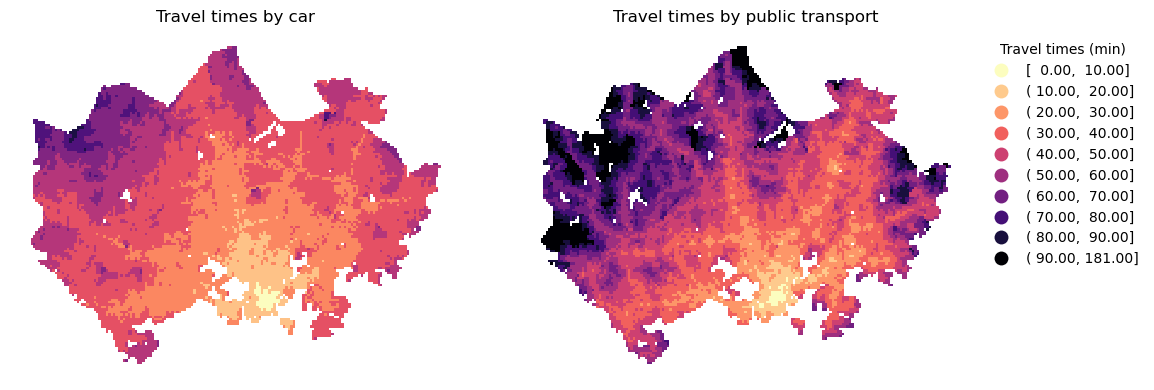

In [14]:
# Create one subplot. Control figure size in here.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(
    ax=axs[0],
    column="car_r_t",
    cmap="magma_r",
    linewidth=0,
    scheme="UserDefined",
    classification_kwds={"bins": break_values},
)

grid.plot(
    ax=axs[1],
    column="pt_r_t",
    cmap="magma_r",
    linewidth=0,
    scheme="UserDefined",
    classification_kwds={"bins": break_values},
    legend=True,
    legend_kwds={
        "title": "Travel times (min)",
        "bbox_to_anchor": (1.4, 1),
        "interval": True,
        "frameon": False,
    },
    label="Travel times by public transport",
)

axs[0].set_title("Travel times by car")
axs[1].set_title("Travel times by public transport")

# Set the x and y axis off and adjust padding around the subplot
axs[0].axis("off")
axs[1].axis("off")

plt.tight_layout()

_**Figure 8.7**. Static map of travel times by car and public transport using a custom classification scheme. Data source: Tenkanen & Toivonen 2020._

## Adding a basemap

Let's now add spatial context using basemaps from online sources. Basemaps might feature satellite imagery or a readily visualized bacground maps displaying various essential features such as streets, administrative boundaries, water bodies and so on.  We can use `contextily` together with `geopandas` and `matplotlib` to fetch map tiles as basemaps for our static maps. Bacground maps are available via `contextily` from various providers: 

In [15]:
print(list(ctx.providers))

['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey', 'UN']


For most of the providers, there are multiple style options available. Here is an example for available OpenStreetMap visualizations: 


In [16]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'CAT'])

Map tiles are typically distributed in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/). We either need to re-project our data before plotting, or set the desired coordinate reference system directly when adding the basemap using `contextily`. Let's plot our data using `geopandas` and add a default basemap for our plot using `contextily` using in the local EPSG:3067 projection which is the CRS of our grid layer.

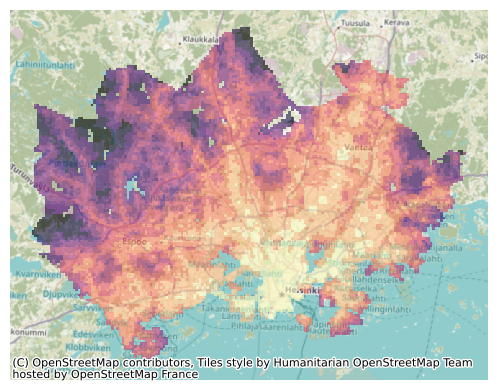

In [17]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="magma_r",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    alpha=0.6,
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap and set crs based on the grid layer
ctx.add_basemap(ax, crs=grid.crs)

_**Figure 8.8**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

We can change the background map easily using the `source` parameter when adding the basemap. We can also customize the map's credits. `Contextily` automatically adds attribution for the background map, and we can modify this text to include credits for the travel time data alongside OpenStreetMap contributors.

In [18]:
credits = "Travel time data by Tenkanen & Toivonen (2020), \
            \nMap Data © OpenStreetMap contributors"

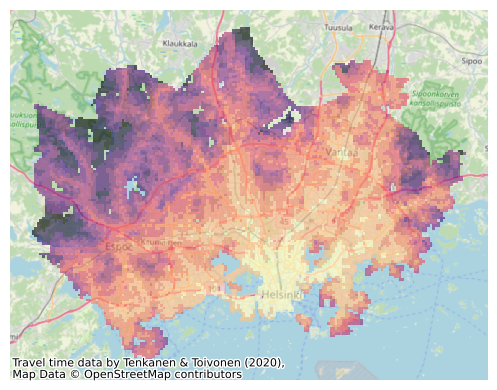

In [19]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="magma_r",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    alpha=0.6,
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(
    ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs
)

_**Figure 8.9**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

 Let's take a subset of our data to see a bit better the background map characteristics. We can, for example, visualize grid squares from where the central railway station can be reached in less than 15 minutes to get a zoomed-in view of the map:

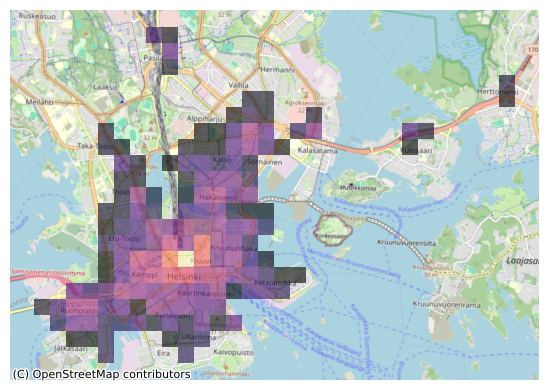

In [20]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

#  Plot only a subset of the data
grid.loc[(grid["pt_r_t"] <= 15)].plot(
    ax=ax, column="pt_r_t", cmap="magma_r", linewidth=0, alpha=0.6
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

_**Figure 8.10**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

Now our map has much more details as the zoom level of the background map is larger. This type of map might be useful for quick data exploration purposes. For example, we can observe that most of the short travel times are located in the city center, while the central railway station is also accessible within 15 minutes by public transport from individual locations a bit further away along the train and metro lines (Pasila, Kulosaari and Herttoniemi).

`Contextily` sets the zoom level automatically but it is also possible to control the zoom level manually. The zoom level is by default specified as `auto` and it can be changed by passing in a specified [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have). Let's try reducing the level of detail from our map by passing `zoom=12`:


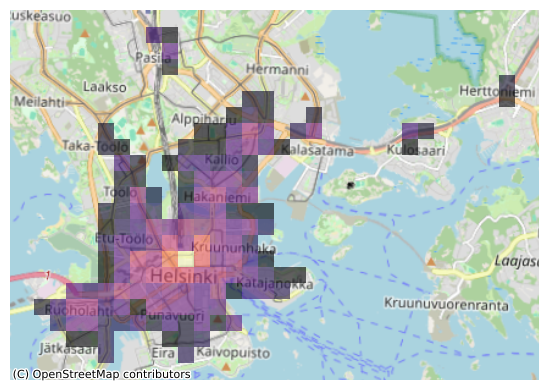

In [21]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

#  Plot only a subset of the data
grid.loc[(grid["pt_r_t"] <= 15)].plot(
    ax=ax, column="pt_r_t", cmap="magma_r", linewidth=0, alpha=0.6
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

_**Figure 8.11**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

With this zoom setting, place names in the bacground map become larger and more readable. 

#### Question 8.2

Explore different background map options and make a final visualization of our travel time data with a basemap, legend and scalebar. 

In [22]:
# Use this cell to enter your solution.

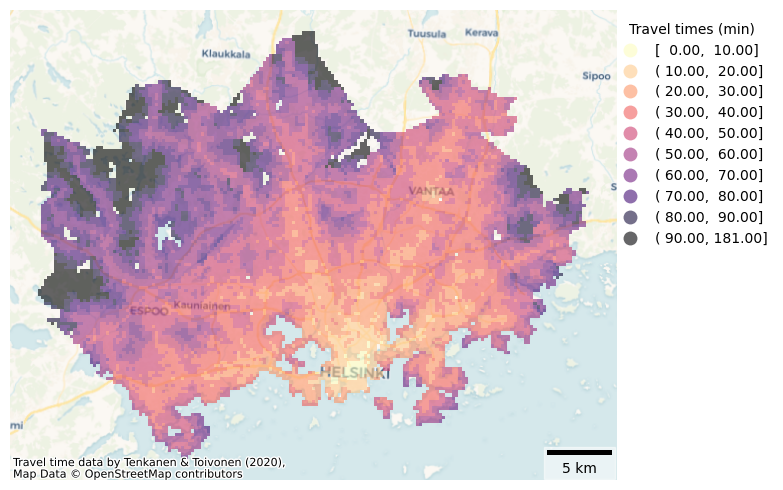

In [23]:
# Solution

# Control figure size in here
fig, ax = plt.subplots(figsize=(8, 5))

# Visualize the travel times using a classification scheme and add a legend
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="magma_r",
    linewidth=0,
    scheme="user_defined",
    classification_kwds={"bins": break_values},
    k=9,
    alpha=0.6,
    legend=True,
    legend_kwds={
        "title": "Travel times (min)",
        "bbox_to_anchor": (1.27, 1),
        "interval": True,
        "frameon": False,
    },
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add scalebar
ax.add_artist(ScaleBar(1, location="lower right", box_alpha=0.5))

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(
    ax, attribution=credits, source=ctx.providers.CartoDB.Voyager, crs=grid.crs
)

## Footnotes
[^geopandas_mappingtools]: <https://geopandas.org/en/stable/docs/user_guide/mapping.html> 
[^matplotlib_pyplot]: <https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html> 
[^contextily]: <https://github.com/darribas/contextily>
[^HSL_opendata]: <https://www.avoindata.fi/data/en_GB/dataset/hsl-n-linjat>
[^matplotlib_colormaps]: <https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib>
[^matplotlib_colors]: <https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors>
[^matplotlib_colorbar]: <https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html>
[^matplotlib_legend]: <https://matplotlib.org/tutorials/intermediate/legend_guide.html>
[^scalebar_geopandas]: <https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html#Adding-a-scale-bar-to-a-matplotlib-plot>
[^pysal]: <https://pysal.org/> 
[^mapclassify]: <https://pysal.org/mapclassify/>
[^geopandas_choro_legends]: <https://geopandas.org/en/stable/gallery/choro_legends.html>